In [1]:
from PEPit import PEP
from PEPit.operators import MonotoneOperator
from PEPit.primitive_steps import proximal_step
import numpy as np
from PEPit.function import Function
import matplotlib.pyplot as plt
import copy
import math
import time
import scipy
from pathlib import Path
import scipy.io
import seaborn as sns

%matplotlib inline

### Define the classes of $\rho$-comonotone operators and $\rho$-star comonotone operators

In [2]:
class NegativeComonotoneOperator(Function):
    def __init__(self,
                 rho=1.,
                 is_leaf=True,
                 decomposition_dict=None,
                 reuse_gradient=True):
        super().__init__(is_leaf=is_leaf,
                         decomposition_dict=decomposition_dict,
                         reuse_gradient=True)

        # Store the rho parameter
        self.rho = rho
        
    def add_class_constraints(self):

        for point_i in self.list_of_points:

            xi, gi, fi = point_i

            for point_j in self.list_of_points:

                xj, gj, fj = point_j

                if (xi != xj) | (gi != gj):
                    # Interpolation conditions of comonotone operator class
                    self.add_constraint((gi - gj) * (xi - xj) + self.rho * (gi - gj) ** 2 >= 0)
                    
class StarNegativeComonotoneOperator(Function):
    def __init__(self,
                 rho=1.,
                 is_leaf=True,
                 decomposition_dict=None,
                 reuse_gradient=True):
        super().__init__(is_leaf=is_leaf,
                         decomposition_dict=decomposition_dict,
                         reuse_gradient=True)

        # Store the rho parameter
        self.rho = rho
        
    def add_class_constraints(self):

        for point_i in self.list_of_stationary_points:

            xi, gi, fi = point_i

            for point_j in self.list_of_points:

                xj, gj, fj = point_j

                if point_i != point_j:
                    # Interpolation conditions of convex functions class
                    self.add_constraint(gj * (xj-xi) + self.rho *  gj ** 2 >= 0)

### Worst-case examples ($\rho$-negative comonotone case)

In [3]:
def wc_proximal_point(alpha, n, rho=1, verbose=1):

    # Instantiate PEP
    problem = PEP()

    # Declare a negative comonotone operator
    A = problem.declare_function(NegativeComonotoneOperator, rho=rho)

    # Start by defining its unique optimal point xs = x_*
    xs = A.stationary_point()

    # Then define the starting point x0 of the algorithm and its gradient value g0
    x0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition((x0 - xs) ** 2 <= 1)

    # Compute n steps of the Proximal Gradient method starting from x0
    generated_sequence = np.array([x0])
    for i in range(n):
        x, _, _ = proximal_step(generated_sequence[i], A, alpha)
        generated_sequence = np.append(generated_sequence, x)

    # Set the performance metric to the distance between x(n) and x(n-1)
    problem.set_performance_metric((generated_sequence[-1] - generated_sequence[-2]) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic='trace')
    th_tau = alpha /(alpha-2*rho)/n
    th_LB = alpha**2/(alpha*(alpha-2*rho)*n*(1+1/n)**(n+1))

    # Print conclusion if required
    if verbose != -1:
        print('*** Example file: worst-case performance of the Proximal Point Method***')
        print('\tPEPit example:\t ||x(n) - x(n-1)||^2 == {:.6} ||x0 - xs||^2'.format(pepit_tau))
        print('\tTheorem 3.1 (paper):\t ||x(n) - x(n-1)||^2 <= {:.6} ||x0 - xs||^2'.format(th_tau))
        print('\tTheorem 3.2 (paper):\t ||x(n) - x(n-1)||^2 >= {:.6} ||x0 - xs||^2'.format(th_LB))
        
    generated_sequence_eval = np.array(generated_sequence[0].eval())
    for i in range(len(generated_sequence)-1):
        generated_sequence_eval = np.vstack((generated_sequence_eval, generated_sequence[i+1].eval()))
    
    # Return the worst-case guarantee of the evaluated method
    return pepit_tau, generated_sequence_eval, xs.eval()

#### Plot worst-case trajectories

In [4]:
%%time
rho = 1
gamma_1 = 2.05
gamma_2 = 3
N = 40

_, generated_sequence_eval_1, xs_1 = wc_proximal_point(alpha=gamma_1, n=N, rho=rho, verbose=1)
_, generated_sequence_eval_2, xs_2 = wc_proximal_point(alpha=gamma_2, n=N, rho=rho, verbose=1)

(PEPit) Setting up the problem: size of the main PSD matrix: 42x42
(PEPit) Setting up the problem: performance measure is minimum of 1 element(s)
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
		 function 1 : 1640 constraint(s) added
(PEPit) Setting up the problem: 0 lmi constraint(s) added
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); optimal value: 0.38185974445564275
(PEPit) Postprocessing: 3 eigenvalue(s) > 1.8933036969464773e-08 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective value: 0.38185974445564275
(PEPit) Postprocessing: 2 eigenvalue(s) > 1.237796642155479e-06 after dimension reduction
(PEPit) Postprocessing: solver's output is not entirely feasible (smallest eigenvalue of the Gram matrix is: -6.33e-10 < 0).
 Small deviation from 0 may si

In [5]:
print(generated_sequence_eval_1)
print(generated_sequence_eval_2)

[[ 4.99999938e-01 -2.83887584e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.12568325e-02 -4.16161151e-05 -8.63703194e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.01678808e+00  2.36987295e-04 -8.26984009e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-1.07524382e+00  1.88636363e-04 -2.32067814e-01 ... -3.21631645e-19
   0.00000000e+00  0.00000000e+00]
 [-9.75831843e-01  9.30026522e-05  3.85738970e-01 ... -3.15488785e-19
  -2.96158082e-20  0.00000000e+00]
 [-3.94637399e-01 -9.48985150e-05  5.95647276e-01 ...  7.02312079e-20
  -5.99288030e-20  8.65658854e-20]]
[[ 4.99999997e-01 -6.10096318e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.51309854e-01 -5.80645878e-05 -2.65827929e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.34325975e-01 -5.09504848e-05 -5.05769421e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-8.74496808e-01  2.28961146e-05  5.0172249

All components except the first one and the third one are negligible

In [6]:
generated_sequence_eval_1 = generated_sequence_eval_1[:,[0,2]]
generated_sequence_eval_2 = generated_sequence_eval_2[:,[0,2]]

operator_values_1 = np.array([generated_sequence_eval_1[0] - generated_sequence_eval_1[1]]) / gamma_1
operator_values_2 = np.array([generated_sequence_eval_2[0] - generated_sequence_eval_2[1]]) / gamma_2

for i in range(len(generated_sequence_eval_1)-2):
    operator_values_1 = np.vstack((operator_values_1, [generated_sequence_eval_1[i+1]/gamma_1
                                                     - generated_sequence_eval_1[i+2]/gamma_1]))
    operator_values_2 = np.vstack((operator_values_2, [generated_sequence_eval_2[i+1]/gamma_2
                                                     - generated_sequence_eval_2[i+2]/gamma_2]))

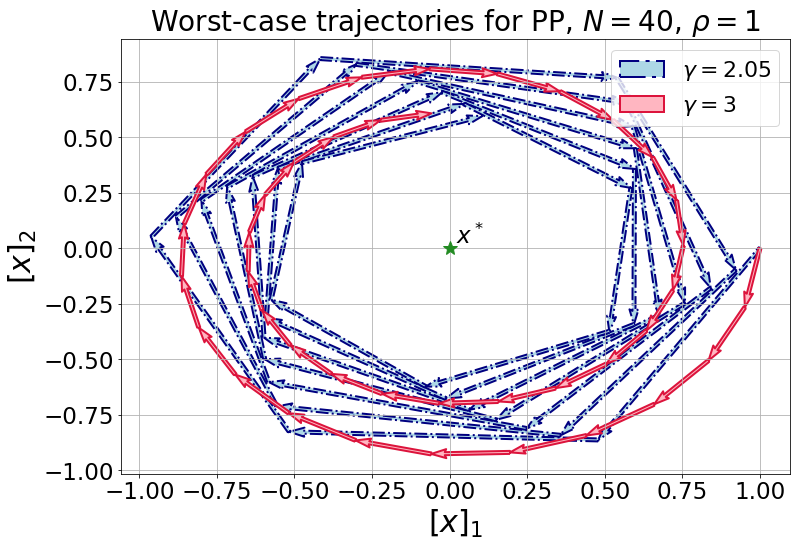

In [7]:
fig = plt.figure(figsize=(12,8))
plt.title(r"Worst-case trajectories for PP, $N = 40$, $\rho = 1$", fontsize=28)

plt.quiver(generated_sequence_eval_1[:-1,0]-xs_1[0], generated_sequence_eval_1[:-1,1]-xs_1[1], 
           -gamma_1*operator_values_1[:,0], -gamma_1*operator_values_1[:,1], angles='xy', scale_units='xy', scale=1,
               width=0.0045, color="navy", ec="navy", label=r"$\gamma = 2.05$", linestyle="dashdot",
           fc='lightblue', linewidth=2)
plt.quiver(generated_sequence_eval_2[:-1,0]-xs_2[0], generated_sequence_eval_2[:-1,1]-xs_2[1], 
           -gamma_2*operator_values_2[:,0], -gamma_2*operator_values_2[:,1], angles='xy', scale_units='xy', scale=1,
               width=0.0045, color="crimson", ec="crimson", label=r"$\gamma = 3$", fc='lightpink', linewidth=2)

plt.plot([0], [0], linewidth=2, markersize = 15, marker = "*", color="forestgreen")
plt.text(0.02,0.02, r'$x^*$',horizontalalignment='left',fontsize=23)


plt.grid()

plt.xlabel(r"$[x]_1$", fontsize=30)
plt.ylabel(r"$[x]_2$", fontsize=30)

plt.legend(loc='upper right', fontsize=22)
plt.xticks(fontsize=23)
_ = plt.yticks(fontsize=23)

ax = fig.gca()
ax.xaxis.offsetText.set_fontsize(28)
ax.yaxis.offsetText.set_fontsize(28)

plt.savefig("plot/Worst-case_trajectores_PP.pdf", bbox_inches='tight')

### $\rho$-star negative comonotone case

In [8]:
def wc_proximal_point_star(alpha, n, rho=1, verbose=1):

    # Instantiate PEP
    problem = PEP()

    # Declare a negative comonotone operator
    A = problem.declare_function(StarNegativeComonotoneOperator)

    # Start by defining its unique optimal point xs = x_*
    xs = A.stationary_point()

    # Then define the starting point x0 of the algorithm and its gradient value g0
    x0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition((x0 - xs) ** 2 <= 1)

    # Compute n steps of the Proximal Gradient method starting from x0
    generated_sequence = np.array([x0])
    obj = 0 * x0**2
    for i in range(n):
        x, _, _ = proximal_step(generated_sequence[i], A, alpha)
        generated_sequence = np.append(generated_sequence, x)
        obj = obj + (x-generated_sequence[i])**2

    # Set the performance metric to the distance between x(n) and x(n-1)
    problem.set_performance_metric(obj/N)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic="logdet3")
    th_tau = alpha /(alpha-2*rho)/n

    # Print conclusion if required
    if verbose != -1:
        print('*** Example file: worst-case performance of the Proximal Point Method***')
        print('\tPEPit example:\t \sum ||x(n) - x(n-1)||^2 == {:.6} ||x0 - xs||^2'.format(pepit_tau))
        print('\tTheorem 3.1 (paper):\t \sum ||x(n) - x(n-1)||^2 <= {:.6} ||x0 - xs||^2'.format(th_tau))
        
    generated_sequence_eval = np.array(generated_sequence[0].eval())
    for i in range(len(generated_sequence)-1):
        generated_sequence_eval = np.vstack((generated_sequence_eval, generated_sequence[i+1].eval()))
    
    # Return the worst-case guarantee of the evaluated method
    return pepit_tau, generated_sequence_eval, xs.eval()

In [9]:
%%time
rho = 1
gamma_1 = 2.05
gamma_2 = 3
N = 40
_, generated_sequence_eval_1, xs_1 = wc_proximal_point_star(alpha=gamma_1, n=N, rho=rho, verbose=1)
_, generated_sequence_eval_2, xs_2 = wc_proximal_point_star(alpha=gamma_2, n=N, rho=rho, verbose=1)

(PEPit) Setting up the problem: size of the main PSD matrix: 42x42
(PEPit) Setting up the problem: performance measure is minimum of 1 element(s)
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
		 function 1 : 40 constraint(s) added
(PEPit) Setting up the problem: 0 lmi constraint(s) added
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); optimal value: 1.0043185977566587
(PEPit) Postprocessing: 2 eigenvalue(s) > 0.00015453764779139637 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective value: 1.0043185977566587
(PEPit) Postprocessing: 1 eigenvalue(s) > 3.452324763530954e-08 after 1 dimension reduction step(s)
(PEPit) Solver status: optimal (solver: MOSEK); objective value: 1.0043185977566587
(PEPit) Postprocessing: 1 eigenvalue(s) > 3.010078740951566e-11 a

In [10]:
print(generated_sequence_eval_1)
print(generated_sequence_eval_2)

[[-5.14288612e-01  2.59536959e-08  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.43808940e+00 -2.93625864e-06 -2.00052874e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.21318197e-01 -2.57271201e-06 -1.99670191e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 3.29114357e-01 -3.14538119e-05 -2.19041833e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.34846697e-01 -3.11117238e-05 -3.14771353e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.43698367e-01 -3.27701686e-05  7.71477146e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[-5.00621113e-01  1.47891575e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.60328435e-01  2.42891235e-01  1.80298361e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.82646777e-01  4.33520679e-01 -8.45456727e-07 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.99766293e-01  7.21027969e-03 -1.5679541

In [11]:
generated_sequence_eval_1 = generated_sequence_eval_1[:,[0,1]]
generated_sequence_eval_2 = generated_sequence_eval_2[:,[0,1]]

operator_values_1 = np.array([generated_sequence_eval_1[0] - generated_sequence_eval_1[1]]) / gamma_1
operator_values_2 = np.array([generated_sequence_eval_2[0] - generated_sequence_eval_2[1]]) / gamma_2

for i in range(len(generated_sequence_eval_1)-2):
    operator_values_1 = np.vstack((operator_values_1, [generated_sequence_eval_1[i+1]/gamma_1
                                                     - generated_sequence_eval_1[i+2]/gamma_1]))
    operator_values_2 = np.vstack((operator_values_2, [generated_sequence_eval_2[i+1]/gamma_2
                                                     - generated_sequence_eval_2[i+2]/gamma_2]))

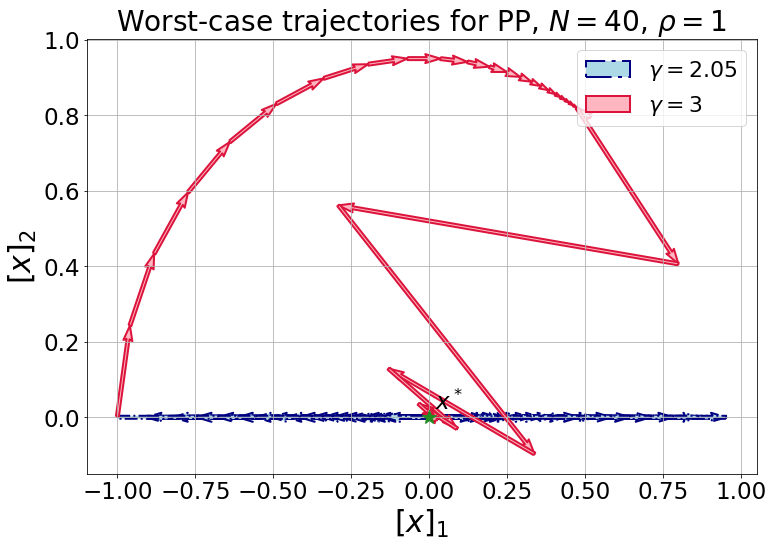

In [12]:
fig = plt.figure(figsize=(12,8))
plt.title(r"Worst-case trajectories for PP, $N = 40$, $\rho = 1$", fontsize=28)

plt.quiver(generated_sequence_eval_1[:-1,0]-xs_1[0], generated_sequence_eval_1[:-1,1]-xs_1[1], 
           -gamma_1*operator_values_1[:,0], -gamma_1*operator_values_1[:,1], angles='xy', scale_units='xy', scale=1,
               width=0.0045, color="navy", ec="navy", label=r"$\gamma = 2.05$", linestyle="dashdot",
           fc='lightblue', linewidth=2)
plt.quiver(generated_sequence_eval_2[:-1,0]-xs_2[0], generated_sequence_eval_2[:-1,1]-xs_2[1], 
           -gamma_2*operator_values_2[:,0], -gamma_2*operator_values_2[:,1], angles='xy', scale_units='xy', scale=1,
               width=0.0045, color="crimson", ec="crimson", label=r"$\gamma = 3$", fc='lightpink', linewidth=2)

plt.plot([0], [0], linewidth=2, markersize = 15, marker = "*", color="forestgreen")
plt.text(0.02,0.02, r'$x^*$',horizontalalignment='left',fontsize=23)


plt.grid()

plt.xlabel(r"$[x]_1$", fontsize=30)
plt.ylabel(r"$[x]_2$", fontsize=30)

plt.legend(loc='upper right', fontsize=22)
plt.xticks(fontsize=23)
_ = plt.yticks(fontsize=23)

ax = fig.gca()
ax.xaxis.offsetText.set_fontsize(28)
ax.yaxis.offsetText.set_fontsize(28)

plt.savefig("plot/Worst-case_trajectores_PP_star.pdf", bbox_inches='tight')